[INFO] Saving plots to: C:\Users\alexp\Documents\Bachelor Thesis\report_figures\results\SHAP\h_200_t_200_210_220_230_iso_4
Pooled rows total: n=30663 across timesteps=[200, 210, 220, 230]

Cluster features (common across all timesteps): ['curvature']
Model features (common across all timesteps):   ['curvature', 'dcurvdx', 'dcurvdy', 'du_ndx', 'du_ndy', 'du_tdx', 'du_tdy', 'normal_strain_rate', 'tangential_strain_rate', 'u_n', 'u_t', 'vorticity']

After dropna on required (cluster+model+target): n=30663
[INFO] Thresholding on z-scored curvature: mean=-3.2375e-02, std=6.4609e-01, thresholds=(-1.0, 1.0)

Threshold clusters summary (pooled):
 cluster     n  sd_mean   sd_std  curv_mean  curv_std
       0  3060 1.174051 0.569898  -1.513333  0.879981
       1 25260 1.063236 0.445966   0.071569  0.266390
       2  2343 1.321580 0.300765   0.781148  0.210288

Cluster occupancy / Sd mean by timestep:
 timestep  cluster    n  sd_mean
      200        0  802 1.022058
      200        1 6412 1.0725

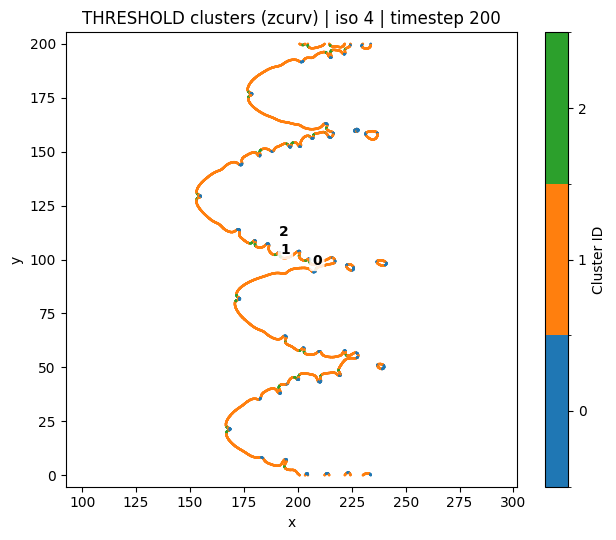

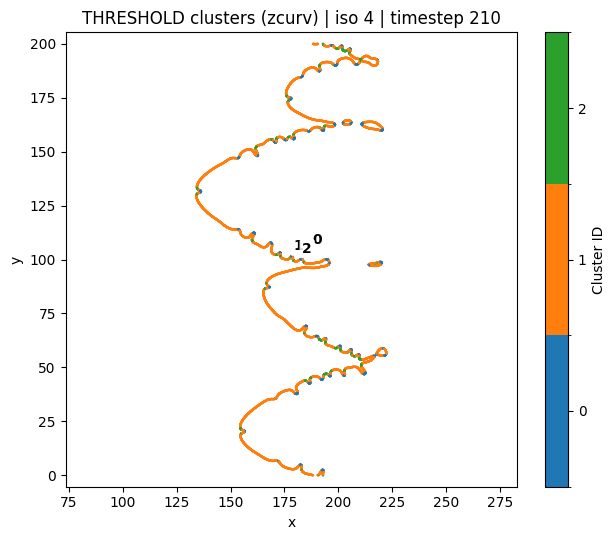

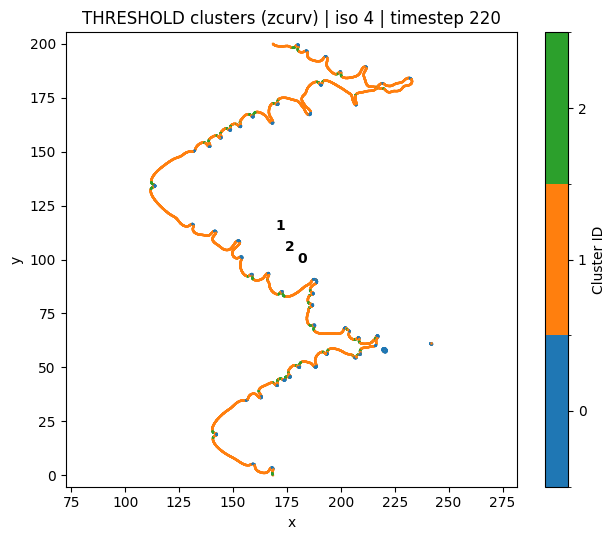

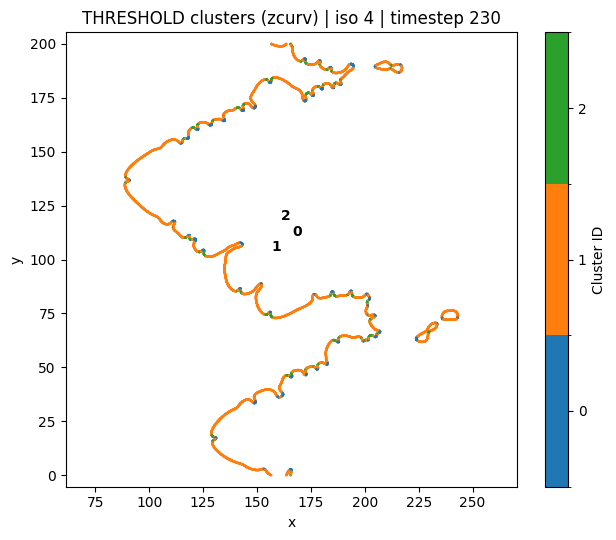


--- Cluster 0 (THRESHOLDS) | n=3060 ---
R^2=0.9009 | RMSE=1.865734e-01
[SHAP timing] X_test=(765, 12), Xs=(765, 12), bg=None | subsample=0.00s, bg=0.00s, build=0.05s, shap=178.97s
Importance method: shap
Top features:
  01. curvature  (3.0894e-01)
  02. dcurvdx  (1.3795e-01)
  03. dcurvdy  (9.9816e-02)
  04. du_ndy  (2.8235e-02)
  05. du_tdy  (2.3340e-02)
  06. vorticity  (1.4477e-02)
  07. u_t  (1.1243e-02)
  08. du_tdx  (1.0215e-02)
  09. du_ndx  (9.7378e-03)
  10. u_n  (9.2921e-03)
  11. normal_strain_rate  (5.0469e-03)
  12. tangential_strain_rate  (3.7147e-03)


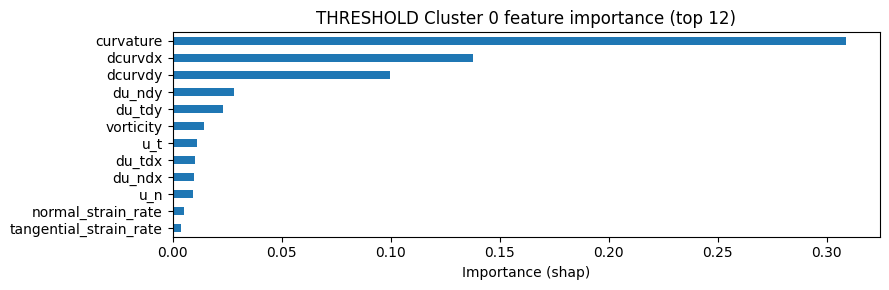


--- Cluster 1 (THRESHOLDS) | n=25260 ---
R^2=0.9764 | RMSE=6.855855e-02


In [ ]:
from __future__ import annotations

from flamekit.io_fronts import Case, load_fronts
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance


# =========================
# USER SETTINGS
# =========================

BASE_DIR = Path("../data/isocontours")
PHI = 0.40
LAT_SIZE = "200"
POST = True

TIME_STEPS = [200, 210, 220, 230]
ISOLEVEL = 4
TARGET_VAR = "DW_FDS"

# We "assume I only use curvature for the clustering" (but now no clustering model is fit)
CLUSTER_FEATURES_INCLUDE = {"curvature"}

# Features used for the RF model + SHAP/permutation importance
# NOTE: fixed missing comma after "curvature" from your file.
MODEL_FEATURES_INCLUDE = {
    "curvature",
    "dcurvdx",
    "dcurvdy",
    "tangential_strain_rate",
    "normal_strain_rate",
    "vorticity",
    "u_n",
    "u_t",
    "du_ndx",
    "du_ndy",
    "du_tdx",
    "du_tdy",
}

FEATURES_EXCLUDE = set()

# We will create exactly 3 bins (clusters) from thresholds
N_CLUSTERS = 3

# Thresholds for 3-way split
THRESHOLDS_ON_ZSCORE = True   # True: apply thresholds on standardized curvature (recommended)
CURV_LOW = -1.0               # below -> cluster 0
CURV_HIGH = +1.0              # above -> cluster 2
# middle band [-1, +1] -> cluster 1

MIN_CLUSTER_SAMPLES = 50
TEST_SIZE = 0.25
RANDOM_STATE = 0

MODEL_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

TOPN_PRINT = 12
TOPN_HEATMAP = 25

PREFER_SHAP = True
SHAP_SAMPLE_MAX = 1000


# =========================
# PLOT SAVING (folder naming convention)
# =========================

OUTPUT_BASE_DIR = Path(r"C:\Users\alexp\Documents\Bachelor Thesis\report_figures\results\SHAP")
TS_TAG = "_".join(map(str, TIME_STEPS))
SAVE_DIR = OUTPUT_BASE_DIR / f"h_{LAT_SIZE}_t_{TS_TAG}_iso_{ISOLEVEL}"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

FIG_DPI = 300

def _safe_name(s: str) -> str:
    return "".join(ch if (ch.isalnum() or ch in "._-") else "_" for ch in s)

def save_png(stem: str, dpi: int = FIG_DPI):
    fname = SAVE_DIR / f"{_safe_name(stem)}.png"
    plt.gcf().savefig(fname, dpi=dpi, bbox_inches="tight", facecolor="white")

def save_then_show(stem: str, dpi: int = FIG_DPI):
    save_png(stem, dpi=dpi)
    plt.show()

print(f"[INFO] Saving plots to: {SAVE_DIR}")


# =========================
# Utilities
# =========================

def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def resolve_features(
        df: pd.DataFrame,
        include: Optional[List[str] | set[str]],
        exclude: set[str],
) -> List[str]:
    num = set(_numeric_cols(df))
    if include is None:
        feats = num
    else:
        feats = set(include).intersection(num)
    feats = feats.difference(exclude)
    return sorted(feats)

def intersect_feature_space(feature_sets: List[set[str]]) -> List[str]:
    if not feature_sets:
        return []
    common = set.intersection(*feature_sets)
    return sorted(common)

def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    # discrete colormap with exactly n_clusters colors
    from matplotlib.colors import ListedColormap, BoundaryNorm
    base = plt.get_cmap("tab10")
    colors = [base(i) for i in range(n_clusters)]
    cmap = ListedColormap(colors)
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, ncolors=n_clusters)

    plt.figure(figsize=(6.5, 5.5))
    sc = plt.scatter(
        dfc["x"], dfc["y"],
        c=dfc["cluster"].astype(int),
        s=3,
        cmap=cmap,
        norm=norm,
        edgecolors="none",
    )
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

    cbar = plt.colorbar(sc, ticks=np.arange(n_clusters), boundaries=boundaries, spacing="proportional")
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])

    centroids_xy = dfc.groupby("cluster")[["x", "y"]].mean().reset_index()
    for _, row in centroids_xy.iterrows():
        cl = int(row["cluster"])
        plt.text(
            row["x"], row["y"], str(cl),
            ha="center", va="center",
            fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, ec="none"),
        )

    plt.tight_layout()
    save_then_show(f"clusters_xy_iso{ISOLEVEL}_ts{dfc['timestep'].iloc[0]}_k{n_clusters}")


from time import perf_counter

def compute_importance(
        model,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        feature_names: List[str],
        prefer_shap: bool = True,
        random_state: int = 0,
        shap_sample_max: int = 500,
        shap_background_max: int = 200,
        shap_feature_perturbation: str = "tree_path_dependent",
        allow_fallback_to_permutation: bool = True,
) -> Tuple[pd.Series, str]:

    if prefer_shap:
        import shap  # type: ignore

        t0 = perf_counter()
        if X_test.shape[0] > shap_sample_max:
            rng = np.random.default_rng(random_state)
            idx = rng.choice(X_test.shape[0], size=shap_sample_max, replace=False)
            Xs = X_test[idx]
        else:
            Xs = X_test
        t1 = perf_counter()

        data_bg = None
        if shap_feature_perturbation == "interventional":
            if X_train.shape[0] > shap_background_max:
                rng = np.random.default_rng(random_state + 123)
                jdx = rng.choice(X_train.shape[0], size=shap_background_max, replace=False)
                data_bg = X_train[jdx]
            else:
                data_bg = X_train
        t2 = perf_counter()

        try:
            explainer = shap.TreeExplainer(
                model,
                data=data_bg,
                feature_perturbation=shap_feature_perturbation,
            )
            t3 = perf_counter()

            sv = explainer(Xs, check_additivity=False)
            shap_vals = sv.values
            t4 = perf_counter()

            imp = np.mean(np.abs(shap_vals), axis=0)
            s = pd.Series(imp, index=feature_names).sort_values(ascending=False)

            print(
                f"[SHAP timing] X_test={X_test.shape}, Xs={Xs.shape}, bg={'None' if data_bg is None else data_bg.shape} | "
                f"subsample={t1 - t0:.2f}s, bg={t2 - t1:.2f}s, build={t3 - t2:.2f}s, shap={t4 - t3:.2f}s"
            )
            return s, "shap"

        except Exception as e:
            print(f"[SHAP FAILED] {type(e).__name__}: {e}")
            if not allow_fallback_to_permutation:
                raise

    pi = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1,
        scoring="r2",
    )
    s = pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False)
    return s, "permutation"


# ============================================================
# LOAD + POOL
# ============================================================

dfs = []
cluster_feature_sets_per_t: List[set[str]] = []
model_feature_sets_per_t: List[set[str]] = []

cluster_include = set(CLUSTER_FEATURES_INCLUDE)
model_include = set(MODEL_FEATURES_INCLUDE)

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    cl_feats_t = set(resolve_features(df_t, cluster_include, FEATURES_EXCLUDE))
    ml_feats_t = set(resolve_features(df_t, model_include, FEATURES_EXCLUDE))

    cluster_feature_sets_per_t.append(cl_feats_t)
    model_feature_sets_per_t.append(ml_feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")

cluster_features = intersect_feature_space(cluster_feature_sets_per_t)
model_features = intersect_feature_space(model_feature_sets_per_t)

if len(cluster_features) == 0:
    raise ValueError("No common numeric CLUSTER features across requested timesteps.")
if len(model_features) == 0:
    raise ValueError("No common numeric MODEL features across requested timesteps.")

print(f"\nCluster features (common across all timesteps): {cluster_features}")
print(f"Model features (common across all timesteps):   {model_features}")

required = sorted(set(cluster_features).union(model_features).union({TARGET_VAR}))
dfc = df_all.dropna(subset=required).copy()
print(f"\nAfter dropna on required (cluster+model+target): n={len(dfc)}")


# ============================================================
# THRESHOLD "CLUSTERING" (NO MODEL FIT)
# ============================================================

if "curvature" not in dfc.columns:
    raise ValueError("Column 'curvature' not found; cannot threshold-split.")

curv = dfc["curvature"].to_numpy(dtype=float)

if THRESHOLDS_ON_ZSCORE:
    mu = float(np.mean(curv))
    sd = float(np.std(curv))
    if not np.isfinite(sd) or sd == 0.0:
        raise ValueError("Curvature standard deviation is zero/invalid; cannot z-score thresholds.")
    curv_used = (curv - mu) / sd
    curv_tag = "zcurv"
    print(f"[INFO] Thresholding on z-scored curvature: mean={mu:.4e}, std={sd:.4e}, thresholds=({CURV_LOW}, {CURV_HIGH})")
else:
    curv_used = curv
    curv_tag = "curv"
    print(f"[INFO] Thresholding on raw curvature: thresholds=({CURV_LOW}, {CURV_HIGH})")

# Assign clusters: 0 (low), 1 (mid), 2 (high)
dfc["cluster"] = np.where(curv_used < CURV_LOW, 0, np.where(curv_used > CURV_HIGH, 2, 1)).astype(int)

# Summary
summary_global = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        curv_mean=("curvature", "mean"),
        curv_std=("curvature", "std"),
    )
    .reset_index()
    .sort_values("cluster")
)
print("\nThreshold clusters summary (pooled):")
print(summary_global.to_string(index=False))

summary_by_t = (
    dfc.groupby(["timestep", "cluster"])
    .agg(n=(TARGET_VAR, "size"), sd_mean=(TARGET_VAR, "mean"))
    .reset_index()
    .sort_values(["timestep", "cluster"])
)
print("\nCluster occupancy / Sd mean by timestep:")
print(summary_by_t.to_string(index=False))

# Spatial plot per timestep
for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts]
    if len(sub) == 0:
        continue
    labeled_cluster_plot_xy(
        sub, N_CLUSTERS,
        title=f"THRESHOLD clusters ({curv_tag}) | iso {ISOLEVEL} | timestep {ts}"
    )


# ============================================================
# Per-cluster RF models + importance
# ============================================================

importances: Dict[int, pd.Series] = {}
metrics: List[dict] = []
trained_models: Dict[int, RandomForestRegressor] = {}
cluster_test_data: Dict[int, dict] = {}

feature_names = list(model_features)

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} (THRESHOLDS) | n={n_cl} ---")

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    X = sub[model_features].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)

    ypred = model.predict(Xte)
    r2 = r2_score(yte, ypred)
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    print(f"R^2={r2:.4f} | RMSE={rmse:.6e}")

    imp, method = compute_importance(
        model=model,
        X_train=Xtr,
        X_test=Xte,
        y_test=yte,
        feature_names=feature_names,
        prefer_shap=PREFER_SHAP,
        random_state=RANDOM_STATE,
        shap_sample_max=SHAP_SAMPLE_MAX,
        shap_background_max=200,
        shap_feature_perturbation="tree_path_dependent",
        allow_fallback_to_permutation=True,
    )

    importances[cl] = imp
    trained_models[cl] = model
    cluster_test_data[cl] = dict(Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte)

    print(f"Importance method: {method}")
    print("Top features:")
    for i, (fname, val) in enumerate(imp.head(TOPN_PRINT).items(), 1):
        print(f"  {i:02d}. {fname}  ({val:.4e})")

    metrics.append({"cluster": cl, "n": n_cl, "r2": float(r2), "rmse": rmse, "importance_method": method})

    top = imp.head(TOPN_PRINT).iloc[::-1]
    plt.figure(figsize=(9, 3))
    top.plot(kind="barh")
    plt.xlabel(f"Importance ({method})")
    plt.title(f"THRESHOLD Cluster {cl} feature importance (top {TOPN_PRINT})")
    plt.tight_layout()
    save_then_show(f"importance_bar_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_thr_{curv_tag}_cluster{cl}_{method}_top{TOPN_PRINT}")


if metrics:
    metrics_df = pd.DataFrame(metrics).sort_values("cluster")
    print("\nPer-cluster model metrics (THRESHOLD clusters):")
    print(metrics_df.to_string(index=False))
else:
    print("\nNo clusters satisfied MIN_CLUSTER_SAMPLES; nothing trained.")


# Compare importances across clusters (heatmap)
if importances:
    trained_clusters = sorted(importances.keys())

    imp_mat = pd.DataFrame(index=feature_names)
    for cl in trained_clusters:
        imp_mat[f"cluster_{cl}"] = importances[cl].reindex(feature_names).fillna(0.0)

    imp_norm = imp_mat.copy()
    for col in imp_norm.columns:
        s = imp_norm[col].sum()
        if s > 0:
            imp_norm[col] /= s

    imp_norm["avg"] = imp_norm.mean(axis=1)
    top_feats = imp_norm.sort_values("avg", ascending=False).head(TOPN_HEATMAP).index
    heat = imp_norm.loc[top_feats, [c for c in imp_norm.columns if c != "avg"]]

    plt.figure(figsize=(1.2 * len(trained_clusters) + 3, 0.35 * len(top_feats) + 2))
    plt.imshow(heat.to_numpy(), aspect="auto")
    plt.xticks(np.arange(len(heat.columns)), heat.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(heat.index)), heat.index)
    plt.colorbar(label="Normalized importance (per cluster)")
    plt.title(f"THRESHOLD clusters ({curv_tag}): importance comparison (top {TOPN_HEATMAP} by avg)")
    plt.tight_layout()
    save_then_show(f"importance_heatmap_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_thr_{curv_tag}_top{TOPN_HEATMAP}")

    print("\nTop features (normalized importance per cluster):")
    print(heat.round(4).to_string())

print(f"Saved PNG plots to: {SAVE_DIR}")
